In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

## Feature Engineering

In [ ]:
import pandas as pd

# df = pd.read_csv('drive/MyDrive/BTC_1sec.csv')
df = pd.read_csv('/content/drive/MyDrive/crypto/ETH_1sec.csv').loc[:10000]

df['best_bid_price'] = df['midpoint'] + 0.5 * df['spread']
df['best_ask_price'] = df['midpoint'] - 0.5 * df['spread']
df['matched_volume'] = df['buys'] + df['sells']

bids_cancel_cols = df.filter(like='bids_cancel_notional_')
df['bids_cancel_notional_0'] = bids_cancel_cols.sum(axis=1)

asks_cancel_cols = df.filter(like='asks_cancel_notional_')
df['asks_cancel_notional_0'] = asks_cancel_cols.sum(axis=1)


columns = [
    'best_ask_price','best_bid_price','matched_volume',
    'bids_cancel_notional_0','asks_cancel_notional_0'
]

for_norm = []

for i in range(1, 6):
    df[f'best_bid_volume_{i}'] = df[f'bids_market_notional_{i}'] + df[f'bids_limit_notional_{i}']
    df[f'best_asks_volume_{i}'] = df[f'asks_market_notional_{i}'] + df[f'asks_limit_notional_{i}']
    columns.append(f'best_bid_volume_{i}')
    columns.append(f'best_asks_volume_{i}')

    for_norm.append(f'best_bid_volume_{i}')
    for_norm.append(f'best_asks_volume_{i}')

df = df[columns]
df

,best_ask_price,best_bid_price,matched_volume,bids_cancel_notional_0,asks_cancel_notional_0,best_bid_volume_1,best_asks_volume_1,best_bid_volume_2,best_asks_volume_2,best_bid_volume_3,best_asks_volume_3,best_bid_volume_4,best_asks_volume_4,best_bid_volume_5,best_asks_volume_5
0,1970.91,1971.06,0.000000,0.000000,0.000000,1031.709961,19998.970703,1970.000000,5913.359863,151.220001,197.110001,749.030029,197.110001,984.849976,2833.530029
1,1970.91,1971.06,0.000000,0.000000,0.000000,1031.709961,19998.970703,1970.000000,5913.359863,151.220001,197.110001,749.030029,197.110001,984.849976,2833.530029
2,1970.91,1971.06,0.000000,0.000000,0.000000,1031.709961,19998.970703,1970.000000,5913.359863,151.220001,197.110001,749.030029,197.110001,984.849976,2833.530029
3,1970.91,1971.06,0.000000,0.000000,0.000000,1031.709961,19998.970703,1970.000000,5913.359863,151.220001,197.110001,749.030029,197.110001,984.849976,2833.530029
4,1971.12,1971.15,5833.970471,49778.510742,10775.830261,197.000000,2841.080078,4995.479980,7716.060059,5980.450195,0.000000,21019.259766,2355.969971,39799.031250,5915.160156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2010.05,2010.33,0.000000,3072.589905,0.000000,3020.000000,0.000000,6987.689941,5000.279785,8430.809570,0.000000,201.139999,0.000000,0.000000,0.000000
9997,2010.31,2010.33,2850.988274,23843.029419,14996.110352,201.169998,2452.750000,3931.340088,2452.760010,35405.531250,1990.609985,4925.330078,5000.279785,29836.630859,2011.020020
9998,2011.13,2011.82,9543.021439,370584.640381,106.900002,1616.349976,0.000000,140138.546875,0.000000,4999.720215,0.000000,35386.960938,0.000000,22683.849609,5040.549805
9999,2011.34,2011.81,1532.379522,12936.969620,5000.279785,3064.679932,2454.419922,4928.240234,5000.279785,3265.929932,0.000000,7021.580078,5000.279785,2725.929932,0.000000


In [ ]:
df = df.iloc[0:5000]
df_cp = df.copy()

## Normalization

In [ ]:
from scipy.stats import zscore
import numpy as np
df = df_cp
# Normalizing the best bid/ask prices to percentage change (Rate of Change, ROC)
df['roc_best_bid_price'] = df['best_bid_price'].pct_change().fillna(0) * 100
df['roc_best_ask_price'] = df['best_ask_price'].pct_change().fillna(0) * 100

df[for_norm] = df[for_norm].applymap(lambda x: max(x, 1e-9))

for i in for_norm:
    df[f'normalized_volume_{i}'] = np.log10(df[i])

count = 0
# Calculate the mean and standard deviation for each column individually
for i in for_norm:
    log_mean = df[f'normalized_volume_{i}'].mean()
    log_std = df[f'normalized_volume_{i}'].std()

    # Check for a zero standard deviation and avoid division by zero
    if log_std != 0:
        df[f'normalized_volume_{i}'] = (df[f'normalized_volume_{i}'] - log_mean) / log_std
    else:
        count += 1
        df[f'normalized_volume_{i}'] = 0  # Or handle the zero variance case as appropriate



for_norm = for_norm + ['best_bid_price','best_ask_price']
df = df.drop(axis=1, columns=for_norm)
print(count)
df

0


,matched_volume,bids_cancel_notional_0,asks_cancel_notional_0,roc_best_bid_price,roc_best_ask_price,normalized_volume_best_bid_volume_1,normalized_volume_best_asks_volume_1,normalized_volume_best_bid_volume_2,normalized_volume_best_asks_volume_2,normalized_volume_best_bid_volume_3,normalized_volume_best_asks_volume_3,normalized_volume_best_bid_volume_4,normalized_volume_best_asks_volume_4,normalized_volume_best_bid_volume_5,normalized_volume_best_asks_volume_5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
4,5833.970471,49778.510742,10775.830261,0.004566,0.010655,0.281883,0.423159,0.603651,0.585633,0.663128,-1.501313,0.791604,0.643009,0.892070,0.751232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,20324.088661,8004.269775,17579.930420,-0.003021,-0.018634,0.559809,0.608771,0.603714,0.587868,0.589958,0.662248,-1.466868,0.827493,-1.353913,-1.308917
4996,24.995018,10652.770020,18907.619690,-0.006043,0.018134,0.419616,0.509514,0.600652,0.684914,0.720354,0.643560,0.685876,-1.382635,0.752096,0.721553
4997,1667.643767,74455.017822,95461.190430,-0.001007,0.000000,0.549632,0.509513,-1.655433,0.588794,-1.537748,-1.501313,0.685876,0.829878,-1.353913,-1.308917
4998,5541.386073,1039.489990,30152.470093,-0.011080,-0.030218,0.301198,0.509504,0.482367,0.592879,0.659474,0.674054,0.685876,0.729415,-1.353913,0.855070


# Model building

## GAN Model

* **Generator**: Contains `dense layer` followed by `two LSTM layers` and a `final dense layer`. It takes a random noise vector *(z)* as input, processes it through layers, and outputs data resembling the real data.
* **Discriminator**: Includes a `dense layer` followed by an `LSTM` and a `final dense layer`. It takes either real data or data generated by the Generator, processes it, and outputs a single value representing the "realness" of the input data.

The choice of this model is highly benefitial due to its **Generator** component, which can generate synthetic market data that mirrors real trading patterns, including `manipulative behaviors`.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)  # Additional LSTM layer
        self.final_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.dense(z)
        lstm_out, _ = self.lstm1(z)
        lstm_out, _ = self.lstm2(lstm_out)  # Pass through the second LSTM
        return torch.tanh(self.final_layer(lstm_out))

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.final_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.dense(x)
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        x = self.final_layer(last_output)
        return torch.sigmoid(x)


## Model Training

During training, it alternates between training the **Discriminator** to distinguish real data from fake data generated by the **Generator** and training the Generator to produce data that the Discriminator will classify as real. The losses for both models are calculated using binary `cross-entropy loss` and are optimized using the `Adam optimizer`. The function also evaluates the model on a validation set and visualizes the training and validation losses after each epoch.

In [ ]:
from IPython.display import display, clear_output

def train_lstm_gans(generator, discriminator, train_loader, val_loader, epochs=1000):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.005)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

    # Lists to store loss values
    losses_d = []
    losses_g = []
    val_losses_d = []
    val_losses_g = []

    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        total_loss_d = 0
        total_loss_g = 0
        num_batches = 0

        # Training loop
        for i, data in enumerate(train_loader):
            print(i, end=' ')
            real_data = data[0]
            real_labels = torch.ones(real_data.size(0), 1)
            discriminator.zero_grad()
            outputs = discriminator(real_data)
            loss_real = criterion(outputs, real_labels)
            loss_real.backward()

            noise = torch.randn(real_data.size(0), 10, 15)  # Adjust dimensions as needed
            fake_data = generator(noise)
            fake_labels = torch.zeros(fake_data.size(0), 1)
            outputs = discriminator(fake_data.detach())
            loss_fake = criterion(outputs, fake_labels)
            loss_fake.backward()
            optimizer_d.step()

            generator.zero_grad()
            outputs = discriminator(fake_data)
            loss_generator = criterion(outputs, real_labels)
            loss_generator.backward()
            optimizer_g.step()

            total_loss_d += loss_real.item() + loss_fake.item()
            total_loss_g += loss_generator.item()
            num_batches += 1

        avg_loss_d = total_loss_d / num_batches
        avg_loss_g = total_loss_g / num_batches
        losses_d.append(avg_loss_d)
        losses_g.append(avg_loss_g)

        # Validation loop
        generator.eval()
        discriminator.eval()
        with torch.no_grad():
            val_loss_d = 0
            val_loss_g = 0
            num_batches_val = 0
            for data in val_loader:
                real_data = data[0]
                real_labels = torch.ones(real_data.size(0), 1)
                outputs = discriminator(real_data)
                loss_real = criterion(outputs, real_labels)

                noise = torch.randn(real_data.size(0), 10, 15)  # Adjust dimensions as needed
                fake_data = generator(noise)
                fake_labels = torch.zeros(fake_data.size(0), 1)
                outputs = discriminator(fake_data)
                loss_fake = criterion(outputs, fake_labels)

                val_loss_d += loss_real.item() + loss_fake.item()
                outputs = discriminator(fake_data)
                loss_generator = criterion(outputs, real_labels)
                val_loss_g += loss_generator.item()
                num_batches_val += 1

            avg_val_loss_d = val_loss_d / num_batches_val
            avg_val_loss_g = val_loss_g / num_batches_val
            val_losses_d.append(avg_val_loss_d)
            val_losses_g.append(avg_val_loss_g)


        # Plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(len(losses_d)), losses_d, label='Train D Loss')
        plt.plot(np.arange(len(val_losses_d)), val_losses_d, label='Val D Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Discriminator Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(losses_g)), losses_g, label='Train G Loss')
        plt.plot(np.arange(len(val_losses_g)), val_losses_g, label='Val G Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Generator Loss')
        plt.legend()

        display(plt.gcf())
        plt.close('all')

        print(f'Epoch [{epoch+1}/{epochs}]: Loss D: {avg_loss_d:.4f}, Loss G: {avg_loss_g:.4f}')

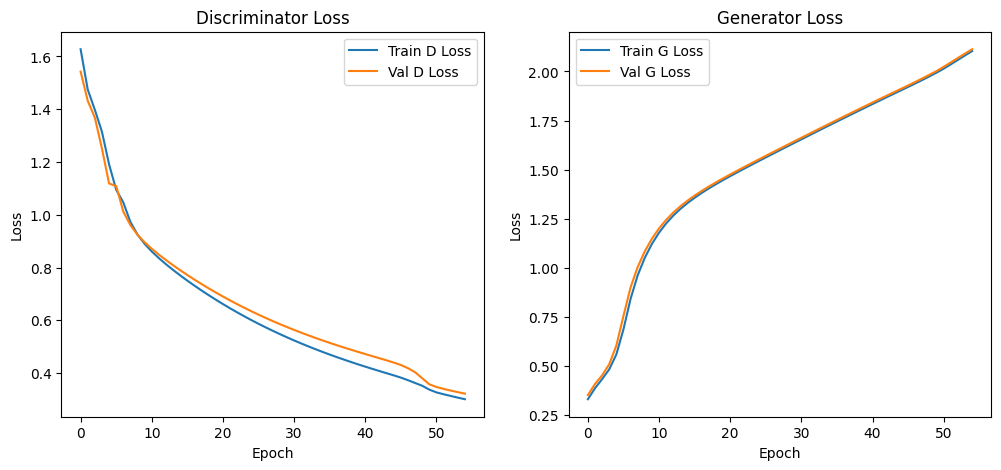

Epoch [55/55]: Loss D: 0.3007, Loss G: 2.1036


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

seq_length = 10
sequential_data = create_sequences(df.values, seq_length)
# Assuming sequential_data is your data array with shape [samples, sequence_length, features]
# Decide on split proportions
train_split = 0.7
val_split = 0.15
# The test_split would implicitly be 0.15 if you want the splits to sum to 1.0

# Calculate the indices for splitting
total_samples = len(sequential_data)
train_end = int(total_samples * train_split)
val_end = train_end + int(total_samples * val_split)

# Split the data
train_data = sequential_data[:train_end]
val_data = sequential_data[train_end:val_end]
test_data = sequential_data[val_end:]

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data.astype(np.float32))
val_tensor = torch.tensor(val_data.astype(np.float32))
test_tensor = torch.tensor(test_data.astype(np.float32))

# Create TensorDatasets and DataLoader for train, validation, and test sets
train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

batch_size = 512  # Adjust as necessary
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Shuffling is not needed for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now, you can proceed to initialize your models and start training
epochs = 55  # Or any number of epochs you wish to train for


input_dim = 15
hidden_dim = 1024  # Example value, adjust as needed
output_dim_generator = 15   # Matching the number of input features
output_dim_discriminator = 1  # Binary output for real vs. generated classification

generator = Generator(input_dim, hidden_dim, output_dim_generator)
discriminator = Discriminator(input_dim, output_dim_discriminator)


train_lstm_gans(generator, discriminator, train_loader, val_loader, epochs=epochs)


## Evaluation on train data

In [ ]:
def evaluate_discriminator(discriminator, generator, test_loader, device=torch.device('cpu')):
    # Keep the discriminator in evaluation mode
    discriminator.eval()

    total = 0
    correct = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for real_data in test_loader:
            # Get real data and classify
            inputs = real_data[0].to(device)
            real_labels = torch.ones(inputs.size(0), 1, device=device)
            outputs_real = discriminator(inputs)
            predicted_real = (outputs_real >= 0.5).float()
            # print(predicted_real.sum())

            # Count correct predictions for real data
            correct += (predicted_real == real_labels).sum().item()

            # Generate fake data and classify
            noise = torch.randn(real_data[0].size(0), 10, input_dim, device=device)
            fake_data = generator(noise)
            fake_labels = torch.zeros(fake_data.size(0), 1, device=device)
            outputs_fake = discriminator(fake_data)
            predicted_fake = (outputs_fake < 0.5).float()
            # print(predicted_fake)

            # Count correct predictions for fake data
            correct += (predicted_fake == fake_labels).sum().item()
            total += real_labels.size(0) + fake_labels.size(0)
            # total += real_labels.size(0)

    # Calculate the accuracy
    accuracy = correct / total
    print("Number of correct:",correct, "\nNumber of total:",total)
    print(f'Discriminator accuracy on the test set is: {accuracy:.4f} or {100 * accuracy:.2f}%')

    # Return discriminator to training mode
    discriminator.train()

    return accuracy

# Set the device ('cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move models to the appropriate device
generator.to(device)
discriminator.to(device)

# Call the evaluation function
evaluate_discriminator(discriminator, generator, train_loader, device)
evaluate_discriminator(discriminator, generator, test_loader, device)

Number of correct: 3490 
Number of total: 6986
Discriminator accuracy on the test set is: 0.4996 or 49.96%
Number of correct: 749 
Number of total: 1498
Discriminator accuracy on the test set is: 0.5000 or 50.00%


0.5

# Manipulations

This code injects synthetic price manipulation into financial data, simulating a pump-and-dump scheme. In the "pumping" phase (`pumping_period = 4sec`), it artificially increases the 'rate of change' by **0.1%** of bid and ask prices (`roc_best_bid_price`, `roc_best_ask_price`) and bid volumes (`normalized_volume_best_bid_volume_*`) to simulate an increase in price and trading volume, creating the illusion of a thriving market.

In [ ]:
import numpy as np
import pandas as pd

def inject_manipulation(data, start_point, manipulation_duration=5, pumping_period=4, increase_rate=0.1, volume_increase=0.2):
    manipulated_data = data.copy()

    pump_indices = range(start_point, start_point + pumping_period)
    dump_index = start_point + pumping_period

    # Increase prices during the pumping period
    for col in ['roc_best_bid_price', 'roc_best_ask_price']:
        manipulated_data.loc[pump_indices, col] *= (1 + increase_rate)

    # Increase bid volumes and calculate new bids
    new_bids = 0
    for i in range(1, 6):
        bid_vol_col = f'normalized_volume_best_bid_volume_{i}'
        original_volumes = manipulated_data.loc[pump_indices, bid_vol_col]
        increased_volumes = original_volumes * (1 + volume_increase)
        new_bids += (increased_volumes - original_volumes).sum()
        manipulated_data.loc[pump_indices, bid_vol_col] = increased_volumes

    # Handle dumping period
    manipulated_data.at[dump_index, 'bids_cancel_notional_0'] += new_bids
    # Uncomment and modify the following lines if bid volumes should be set to 0 or nominal values in the dumping period
    # for i in range(1, 6):
    #     manipulated_data.at[dump_index, f'normalized_volume_best_bid_volume_{i}'] = 0  # Or set to a nominal value

    # Handle ask volume in the dumping period
    ask_vol_cols = [f'normalized_volume_best_asks_volume_{i}' for i in range(1, 6)]
    base_volume = manipulated_data.loc[start_point, ask_vol_cols].sum()
    manipulated_data.at[dump_index, 'normalized_volume_best_asks_volume_1'] = 4 * base_volume

    return manipulated_data

# Injecting manipulation patterns
manipulated_data = df.copy()
manipulation_duration = 5
for i in range(100):
    start_point = np.random.randint(0, len(manipulated_data) - manipulation_duration)
    manipulated_data = inject_manipulation(manipulated_data, start_point)

manipulated_data

,matched_volume,bids_cancel_notional_0,asks_cancel_notional_0,roc_best_bid_price,roc_best_ask_price,normalized_volume_best_bid_volume_1,normalized_volume_best_asks_volume_1,normalized_volume_best_bid_volume_2,normalized_volume_best_asks_volume_2,normalized_volume_best_bid_volume_3,normalized_volume_best_asks_volume_3,normalized_volume_best_bid_volume_4,normalized_volume_best_asks_volume_4,normalized_volume_best_bid_volume_5,normalized_volume_best_asks_volume_5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.418971,0.587083,0.531760,0.565122,0.388013,0.395017,0.546117,0.466601,0.626761,0.699674
4,5833.970471,49778.510742,10775.830261,0.004566,0.010655,0.281883,0.423159,0.603651,0.585633,0.663128,-1.501313,0.791604,0.643009,0.892070,0.751232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,20324.088661,8004.269775,17579.930420,-0.003021,-0.018634,0.559809,0.608771,0.603714,0.587868,0.589958,0.662248,-1.466868,0.827493,-1.353913,-1.308917
4996,24.995018,10652.770020,18907.619690,-0.006043,0.018134,0.419616,0.509514,0.600652,0.684914,0.720354,0.643560,0.685876,-1.382635,0.752096,0.721553
4997,1667.643767,74455.017822,95461.190430,-0.001007,0.000000,0.549632,0.509513,-1.655433,0.588794,-1.537748,-1.501313,0.685876,0.829878,-1.353913,-1.308917
4998,5541.386073,1039.489990,30152.470093,-0.011080,-0.030218,0.301198,0.509504,0.482367,0.592879,0.659474,0.674054,0.685876,0.729415,-1.353913,0.855070


## Testing on manipulations

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming df is your DataFrame and you want sequences of length 10
seq_length = 10
sequential_data = create_sequences(manipulated_data.values, seq_length)

# Split the data into train and test sets
train_data, test_data = train_test_split(sequential_data, test_size=0.3, random_state=42)

print("The shape of the train_data", train_data.shape)

# Convert train and test data to PyTorch Tensors
train_tensor = torch.tensor(train_data.astype(np.float32))
test_tensor = torch.tensor(test_data.astype(np.float32))

# Create TensorDatasets and DataLoader for train and test sets
train_dataset = TensorDataset(train_tensor)
test_dataset = TensorDataset(test_tensor)

# Set batch size and shuffle for DataLoader
batch_size = 512
train_loader_manp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_manp = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

evaluate_discriminator(discriminator, generator, train_loader_manp, device)
evaluate_discriminator(discriminator, generator, test_loader_manp, device)

The shape of the train_data (3493, 10, 15)
Number of correct: 3479 
Number of total: 6986
Discriminator accuracy on the test set is: 0.4980 or 49.80%
Number of correct: 1491 
Number of total: 2994
Discriminator accuracy on the test set is: 0.4980 or 49.80%


0.49799599198396793